In [25]:
import requests
from datetime import datetime as dt

In [26]:
# IMPORT DATA FROM WEB API

url = 'https://api.weather.gov/'
coords = '40.7128,-74.0060' # latitude North, longitude East

res = requests.get(f'{url}points/{coords}')
res = res.json()

properties = res.get('properties')
gridid = properties.get('gridId')
gridx = properties.get('gridX')
gridy = properties.get('gridY')

In [27]:
data = requests.get(f'{url}gridpoints/{gridid}/{gridx},{gridy}')
data = data.json()
pos = data.get('geometry').get('coordinates')[0][0]
data = data.get('properties').get('temperature').get('values')

timeseries = []
temps = []

for item in data:
    date = item.get('validTime')
    date = dt.strptime(date.split('/')[0], '%Y-%m-%dT%H:%M:%S%z')
    timeseries.append(date)
    temp = item.get('value')
    temps.append(temp)

print(pos, len(timeseries), len(temps))

base_time = timeseries[0]
time_vals = []

for t in timeseries:
    val = t - base_time
    ts = val.total_seconds()
    time_vals.append(ts)

time_units = "seconds since " + base_time.strftime('%Y-%m-%d %H:%M:%S')
print(time_units)

[-74.0250952, 40.7270524] 128 128
seconds since 2021-09-17 08:00:00


In [29]:
# EXPORT DATA TO NETCDF4

import netCDF4 as nc
import numpy as np

fn = f'/Users/kazi.mahir/Documents/{gridid}-temps.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

time_dim = ds.createDimension('time', None)

time_var = ds.createVariable('time', np.float, ('time',))
time_var[:] = time_vals
time_var.units = time_units
time_var.standard_name = 'time'
time_var.calendar = 'standard'

temp = ds.createVariable('temp', np.float, ('time',))
temp[:] = temps
temp.var_id = 'temp'
temp.long_name = 'temperature of air (degrees C)'
temp.units = 'degrees C'
temp.standard_name = 'air_temperature'

ds.Conventions = "CF-1.6"
ds.institution = 'NCAS'
ds.title = "my first cf-netcdf file"
ds.location = f'latitude N: {pos[1]}, longitude E: {pos[0]}'

ds.close()

PermissionError: [Errno 13] Permission denied: b'/Users/kazi.mahir/Documents/OKX-temps.nc'

In [30]:
# IMPORT NETCDF4

from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt

net_data = Dataset(fn, mode='r')

temps = net_data.variables['temp'][:]
times = net_data.variables['time'][:]

datetimes = num2date(times[:],
                     units=net_data.variables['time'].units,
                     calendar=net_data.variables['time'].calendar)

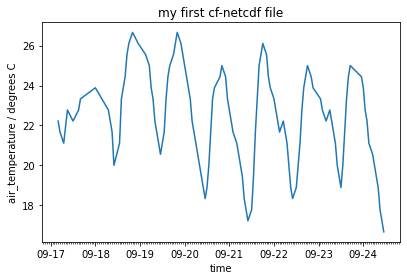

In [31]:
# PLOT NETCDF DATA

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fmt_day = mdates.DayLocator()
fmt_hour = mdates.HourLocator()

fig, ax = plt.subplots()

ax.xaxis.set_major_locator(fmt_day)
ax.xaxis.set_minor_locator(fmt_hour)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xlabel(net_data.variables['time'].standard_name)
plt.ylabel(net_data.variables['temp'].standard_name + ' / ' + net_data.variables['temp'].units)
plt.title(net_data.title)

fig.tight_layout()
plt.plot_date(datetimes, temps, '-')
